# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.3 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [6]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [7]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [8]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [9]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 128
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)
len(train_dataloader)

938

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [10]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

### Запуск базовой модели с семинара на новом датасете (1 балл)

In [11]:
class CharLM(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        vocab_size: int,
        num_classes: int = 4,
        aggregation_type: str = 'max',
        type_nn: str = 'rnn', # rnn / gru / lstm,
        num_layers: int = 1,
        ):

        super().__init__()

        self.type_nn = type_nn

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        rnn_type = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[type_nn]
        self.rnn = rnn_type(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab), num_classes=4).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean', 'max']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='rnn'

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.25759997963905334
res_eval = 0.8413999676704407


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8589999675750732
res_eval = 0.8881999850273132


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8913999795913696
res_eval = 0.8977999687194824


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.88919997215271
res_eval = 0.897599995136261


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9005999565124512
res_eval = 0.902999997138977
Starting training for max


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.24699999392032623
res_eval = 0.8736000061035156


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8923999667167664
res_eval = 0.8980000019073486


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8991999626159668
res_eval = 0.8965999484062195


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9065999984741211
res_eval = 0.9007999897003174


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9025999903678894
res_eval = 0.8987999558448792


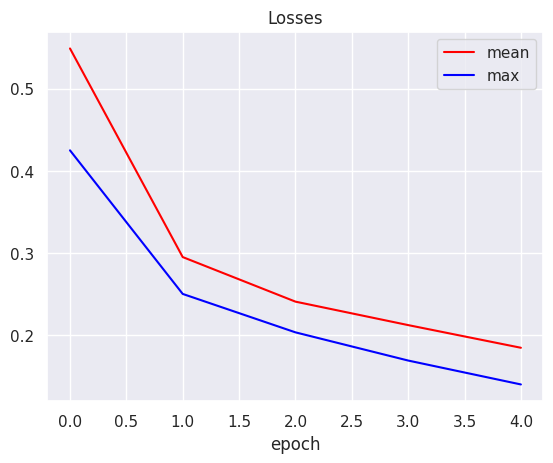

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 90.30
Лучшая accuracy для подхода max: 90.66


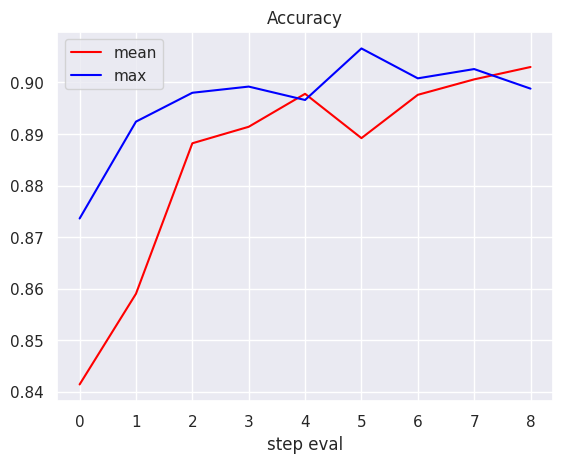

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**бейзлайн - 90.3 (лучше при aggregation_type = 'mean' - более стабильно, для дальнейших расчетов оставляем mean)**

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)

#### эксперимент 1 - GRU вместо RNN

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='gru'

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.2531999945640564
res_eval = 0.8751999735832214


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.896399974822998
res_eval = 0.8987999558448792


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8989999890327454
res_eval = 0.8971999883651733


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9073999524116516
res_eval = 0.9027999639511108


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9043999910354614
res_eval = 0.9103999733924866


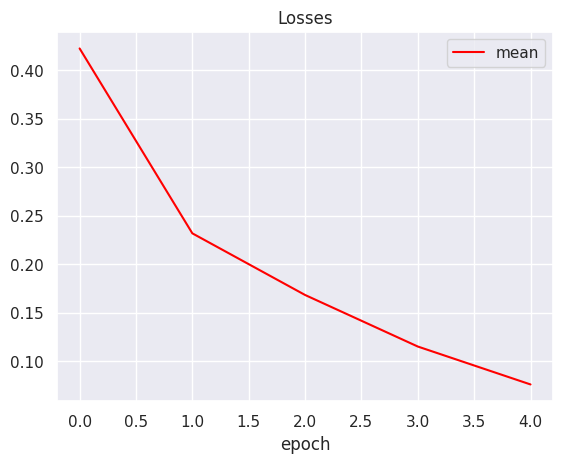

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.04


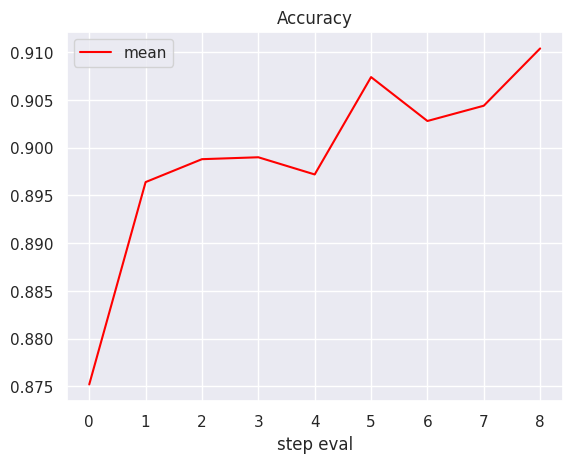

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**видим улучшение, метрика = 91.04 (при этом по графику лоса видим, что модель еще не дообучена, можно увеличить число эпох - см. эксперимент 3)**

#### эксперимент 2 - увеличиваем количество слоев

In [ ]:
num_epoch = 5
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='gru',
        num_layers=3

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.24939998984336853
res_eval = 0.8755999803543091


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8991999626159668
res_eval = 0.8995999693870544


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9073999524116516
res_eval = 0.9083999991416931


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9101999998092651
res_eval = 0.9081999659538269


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9099999666213989
res_eval = 0.9106000065803528


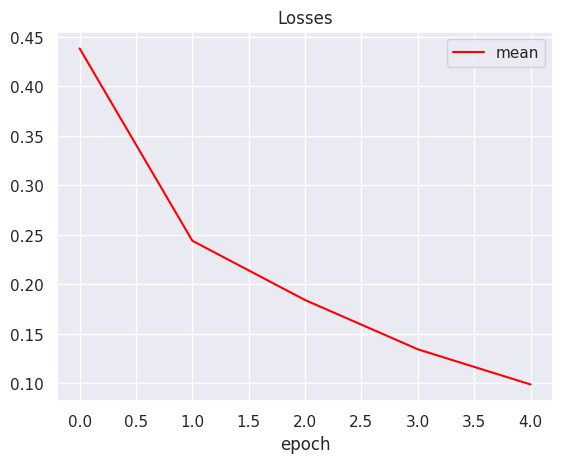

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.06


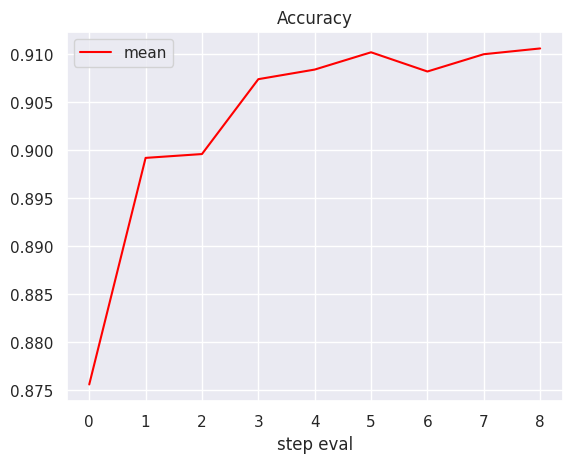

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**видим улучшение, метрика = 91.06 (при этом по графику лоса видим, что модель еще не дообучена, можно увеличить число эпох - см. эксперимент 3)**

#### эксперимент 3 - увеличим число эпох

In [ ]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='gru',
        num_layers=3

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.23959998786449432
res_eval = 0.8737999796867371


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8885999917984009
res_eval = 0.899399995803833


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9025999903678894
res_eval = 0.9065999984741211


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9075999855995178
res_eval = 0.9088000059127808


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9131999611854553
res_eval = 0.9045999646186829


Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9063999652862549
res_eval = 0.9081999659538269


Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9070000052452087
res_eval = 0.9085999727249146


Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9052000045776367
res_eval = 0.9097999930381775


Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9045999646186829
res_eval = 0.9027999639511108


Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9045999646186829
res_eval = 0.9067999720573425


Training epoch 10::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9049999713897705
res_eval = 0.8998000025749207


Training epoch 11::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9023999571800232
res_eval = 0.9049999713897705


Training epoch 12::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9052000045776367
res_eval = 0.9027999639511108


Training epoch 13::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9023999571800232
res_eval = 0.9089999794960022


Training epoch 14::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9017999768257141
res_eval = 0.8983999490737915


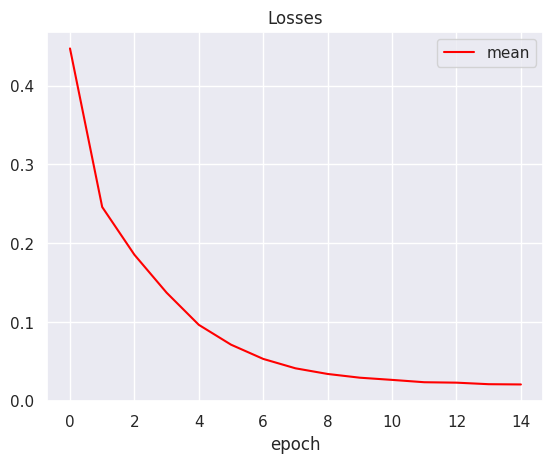

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.32


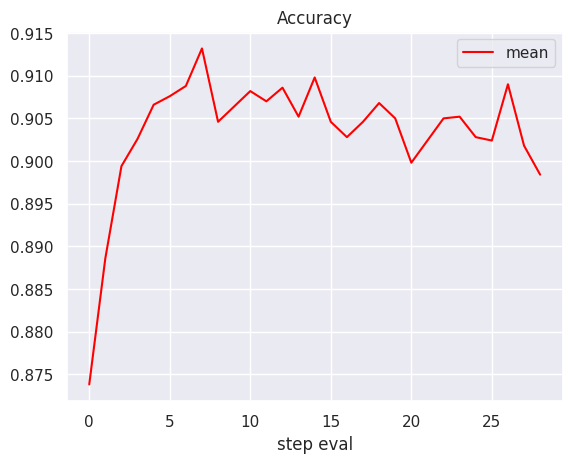

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**видим улучшение, метрика = 91.32 (при этом по графику метрики видим, что обучение не стабильно, можно попробовать взять меньше шаг оптимизатора - см. эксперимент 4)**

#### эксперимент 4 - уменьшим шаг оптимизатора

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=256,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='gru',
        num_layers=3

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(num_epoch):
        print(f'epoch = {epoch}, lr = {optimizer.param_groups[0]["lr"]}')
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()
        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean
epoch = 0, lr = 0.0001


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.2572000026702881
res_eval = 0.7839999794960022
epoch = 1, lr = 0.0001


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8416000008583069
res_eval = 0.8471999764442444
epoch = 2, lr = 0.0001


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8729999661445618
res_eval = 0.8733999729156494
epoch = 3, lr = 0.0001


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8837999701499939
res_eval = 0.8883999586105347
epoch = 4, lr = 0.0001


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8881999850273132
res_eval = 0.8877999782562256
epoch = 5, lr = 0.0001


Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8867999911308289
res_eval = 0.8885999917984009
epoch = 6, lr = 0.0001


Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8917999863624573
res_eval = 0.8907999992370605
epoch = 7, lr = 0.0001


Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.895799994468689
res_eval = 0.8983999490737915
epoch = 8, lr = 0.0001


Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8971999883651733
res_eval = 0.8925999999046326
epoch = 9, lr = 0.0001


Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8959999680519104
res_eval = 0.8883999586105347
epoch = 10, lr = 0.0001


Training epoch 10::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.897599995136261
res_eval = 0.8953999876976013
epoch = 11, lr = 0.0001


Training epoch 11::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8935999870300293
res_eval = 0.8944000005722046
epoch = 12, lr = 0.0001


Training epoch 12::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8921999931335449
res_eval = 0.8959999680519104
epoch = 13, lr = 0.0001


Training epoch 13::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8935999870300293
res_eval = 0.8930000066757202
epoch = 14, lr = 0.0001


Training epoch 14::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8947999477386475
res_eval = 0.896399974822998


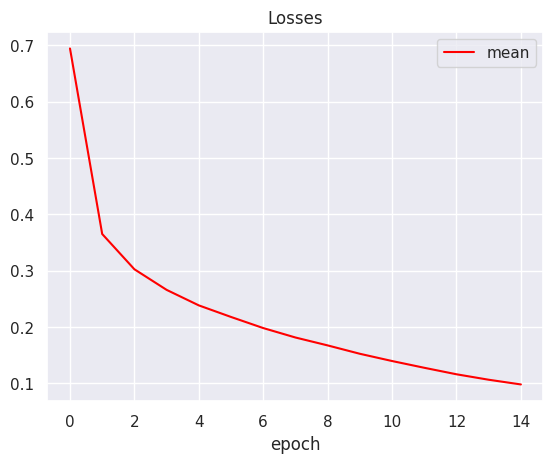

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 89.84


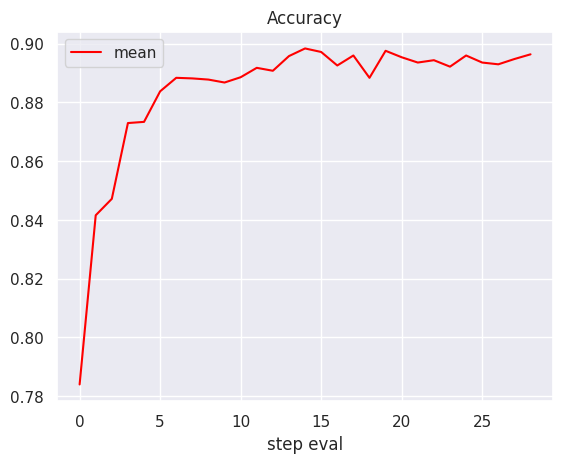

In [ ]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**видим ухудшение, метрика = 89.94 (при этом график метрики стабилизировался)**

#### эксперимент 5 - увеличим hidden_dim, остальные параметры с эксперимента 3

In [12]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=512,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='gru',
        num_layers=3

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(num_epoch):
        print(f'epoch = {epoch}, lr = {optimizer.param_groups[0]["lr"]}')
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()
        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean
epoch = 0, lr = 0.001


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.25679999589920044
res_eval = 0.8883999586105347
epoch = 1, lr = 0.001


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9045999646186829
res_eval = 0.8971999883651733
epoch = 2, lr = 0.001


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9109999537467957
res_eval = 0.9115999937057495
epoch = 3, lr = 0.001


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9101999998092651
res_eval = 0.9120000004768372
epoch = 4, lr = 0.001


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9103999733924866
res_eval = 0.9106000065803528
epoch = 5, lr = 0.001


Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9075999855995178
res_eval = 0.9107999801635742
epoch = 6, lr = 0.001


Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9077999591827393
res_eval = 0.9061999917030334
epoch = 7, lr = 0.001


Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9107999801635742
res_eval = 0.9088000059127808
epoch = 8, lr = 0.001


Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.8998000025749207
res_eval = 0.9017999768257141
epoch = 9, lr = 0.001


Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9089999794960022
res_eval = 0.9079999923706055
epoch = 10, lr = 0.001


Training epoch 10::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9089999794960022
res_eval = 0.9088000059127808
epoch = 11, lr = 0.001


Training epoch 11::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9067999720573425
res_eval = 0.9021999835968018
epoch = 12, lr = 0.001


Training epoch 12::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9073999524116516
res_eval = 0.9031999707221985
epoch = 13, lr = 0.001


Training epoch 13::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9034000039100647
res_eval = 0.9077999591827393
epoch = 14, lr = 0.001


Training epoch 14::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9065999984741211
res_eval = 0.9045999646186829


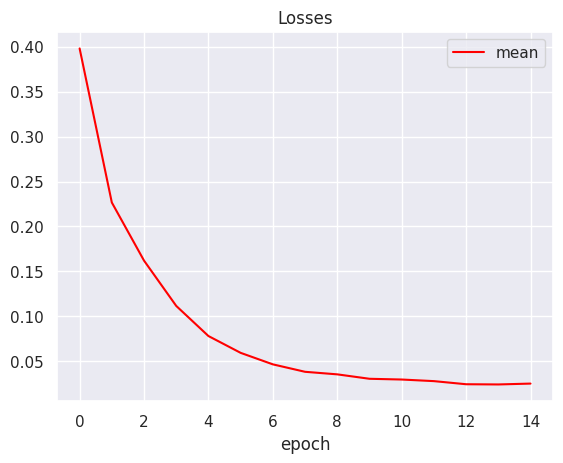

In [13]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.20


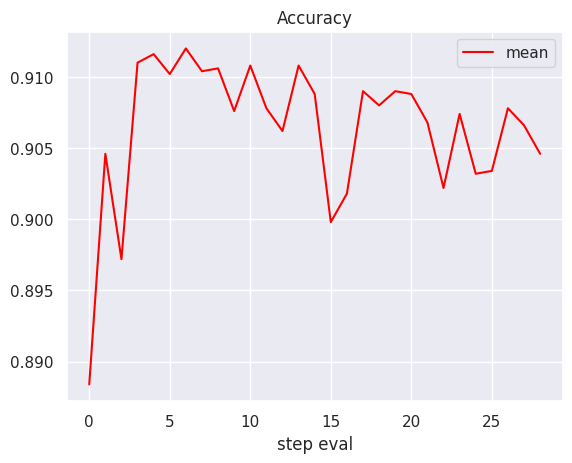

In [14]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**улучшения метрики нет, метрика = 91.2 (при этом график метрики немного стабилизировался, можно попробовать взять переменный шаг оптимизатора - см. эксперимент 6)**

#### эксперимент 6 - введем переменный шаг оптимизатора

In [15]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=512,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='gru',
        num_layers=3

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    # изменить шаг оптимизатора в 0,9 раз каждую эпоху
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # ExponentialLR / StepLR

    for epoch in range(num_epoch):
        print(f'epoch = {epoch}, lr = {optimizer.param_groups[0]["lr"]}')
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()
        losses.append(sum(epoch_losses) / len(epoch_losses))
        scheduler.step()

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean
epoch = 0, lr = 0.001


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.33379998803138733
res_eval = 0.8804000020027161
epoch = 1, lr = 0.0009000000000000001


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9049999713897705
res_eval = 0.9027999639511108
epoch = 2, lr = 0.0008100000000000001


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9113999605178833
res_eval = 0.9103999733924866
epoch = 3, lr = 0.000729


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9169999957084656
res_eval = 0.9089999794960022
epoch = 4, lr = 0.0006561000000000001


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9107999801635742
res_eval = 0.9097999930381775
epoch = 5, lr = 0.00059049


Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9079999923706055
res_eval = 0.9085999727249146
epoch = 6, lr = 0.000531441


Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9081999659538269
res_eval = 0.9077999591827393
epoch = 7, lr = 0.0004782969


Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9047999978065491
res_eval = 0.9088000059127808
epoch = 8, lr = 0.00043046721


Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9071999788284302
res_eval = 0.9057999849319458
epoch = 9, lr = 0.000387420489


Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9034000039100647
res_eval = 0.9109999537467957
epoch = 10, lr = 0.0003486784401


Training epoch 10::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9059999585151672
res_eval = 0.9075999855995178
epoch = 11, lr = 0.00031381059609000004


Training epoch 11::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9039999842643738
res_eval = 0.9057999849319458
epoch = 12, lr = 0.00028242953648100003


Training epoch 12::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9035999774932861
res_eval = 0.9070000052452087
epoch = 13, lr = 0.00025418658283290005


Training epoch 13::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9089999794960022
res_eval = 0.9075999855995178
epoch = 14, lr = 0.00022876792454961005


Training epoch 14::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9081999659538269
res_eval = 0.9075999855995178


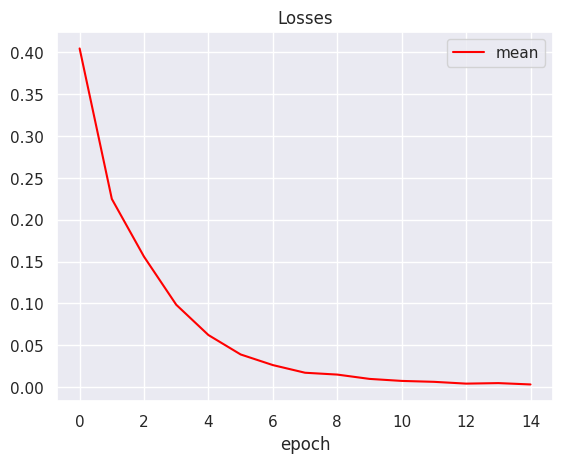

In [16]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.70


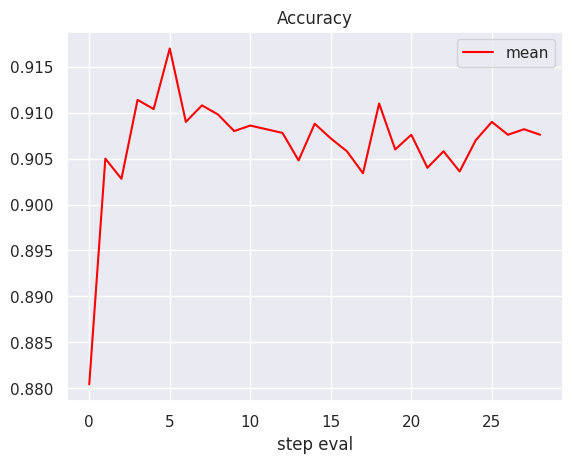

In [17]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**видим улучшение, метрика = 91.7 (метрика немного стабилизировалась)**

#### эксперимент 7 - пробуем LSTM

In [18]:
num_epoch = 10
eval_steps = len(train_dataloader) // 2


losses_type = {}
acc_type = {}

for aggregation_type in ['mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM(
        hidden_dim=512,
        vocab_size=len(vocab),
        aggregation_type=aggregation_type,
        num_classes=4,
        type_nn='lstm',
        num_layers=3

        ).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    # изменить шаг оптимизатора в 0,9 раз каждую эпоху
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # ExponentialLR / StepLR

    for epoch in range(num_epoch):
        print(f'epoch = {epoch}, lr = {optimizer.param_groups[0]["lr"]}')
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                res_eval = evaluate(model)
                acc.append(res_eval)
                print(f'res_eval = {res_eval}')
                model.train()
        losses.append(sum(epoch_losses) / len(epoch_losses))
        scheduler.step()

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for mean
epoch = 0, lr = 0.001


Training epoch 0::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.2393999993801117
res_eval = 0.8835999965667725
epoch = 1, lr = 0.0009000000000000001


Training epoch 1::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9037999510765076
res_eval = 0.9083999991416931
epoch = 2, lr = 0.0008100000000000001


Training epoch 2::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9085999727249146
res_eval = 0.9101999998092651
epoch = 3, lr = 0.000729


Training epoch 3::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9139999747276306
res_eval = 0.9037999510765076
epoch = 4, lr = 0.0006561000000000001


Training epoch 4::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.91239994764328
res_eval = 0.9077999591827393
epoch = 5, lr = 0.00059049


Training epoch 5::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9113999605178833
res_eval = 0.9089999794960022
epoch = 6, lr = 0.000531441


Training epoch 6::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9111999869346619
res_eval = 0.9099999666213989
epoch = 7, lr = 0.0004782969


Training epoch 7::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9063999652862549
res_eval = 0.9139999747276306
epoch = 8, lr = 0.00043046721


Training epoch 8::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9120000004768372
res_eval = 0.9095999598503113
epoch = 9, lr = 0.000387420489


Training epoch 9::   0%|          | 0/938 [00:00<?, ?it/s]

res_eval = 0.9127999544143677
res_eval = 0.915399968624115


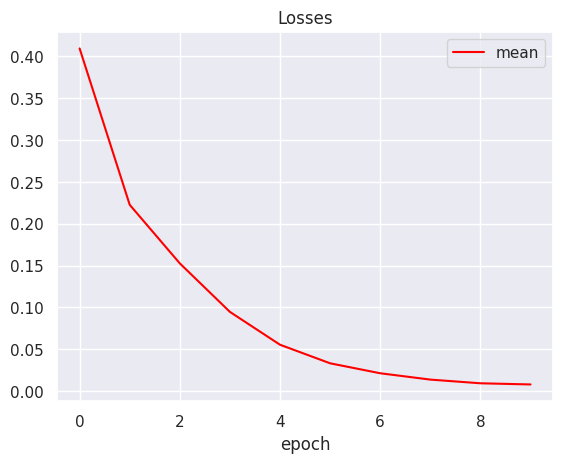

In [19]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода mean: 91.54


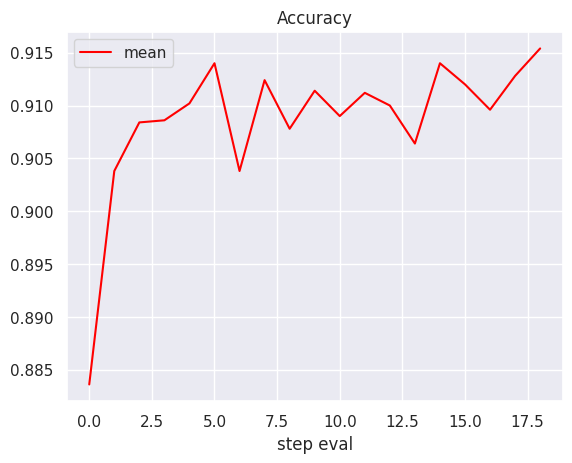

In [20]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("step eval")
plt.legend()
plt.show()

**видим небольшое ухудшение, метрика = 91.54 (но метрика еще стабилизировалась)**

### Получение высокого качества (3 балла)

- **модель из эксперимента 6 дала качество 0,917**
- **модель из эксперимента 7 дала качество 0,9154**

### Оформление отчета (2 балла)

- улучшение принесло:
  - замена слоя RNN на GRU (эксперимент 1)
  - увеличение количества слоев (эксперимент 2)
  - увеличение числа эпох (эксперимент 3)
  - увеличение hidden_dim (эксперимент 5) (метрика по сравнению с эксперимнтом 3 немного понизилась, но немного стабилизировалась)
  - введение переменного щага оптимизатора (эксперимент 6)
  - замена слоя RNN на GRU (эксперимент 7) (метрика по сравнению с эксперимнтом 6 немного понизилась, но стабилизировалась)

- улучшение не принесло:
  - уменьшение шага оптимизатора (эксперимент 4)

- колебания есть, помогло снизить колебания:
    - переменный шаг оптимизатора
    - замена слоя RNN на LSTM

- оптимальная модель - модель из эксперимента 7 с метрикой 0,9154, несмотря на то что в эксперименте 6 метрика 0,917, результат эксперимента 7 более стабилен

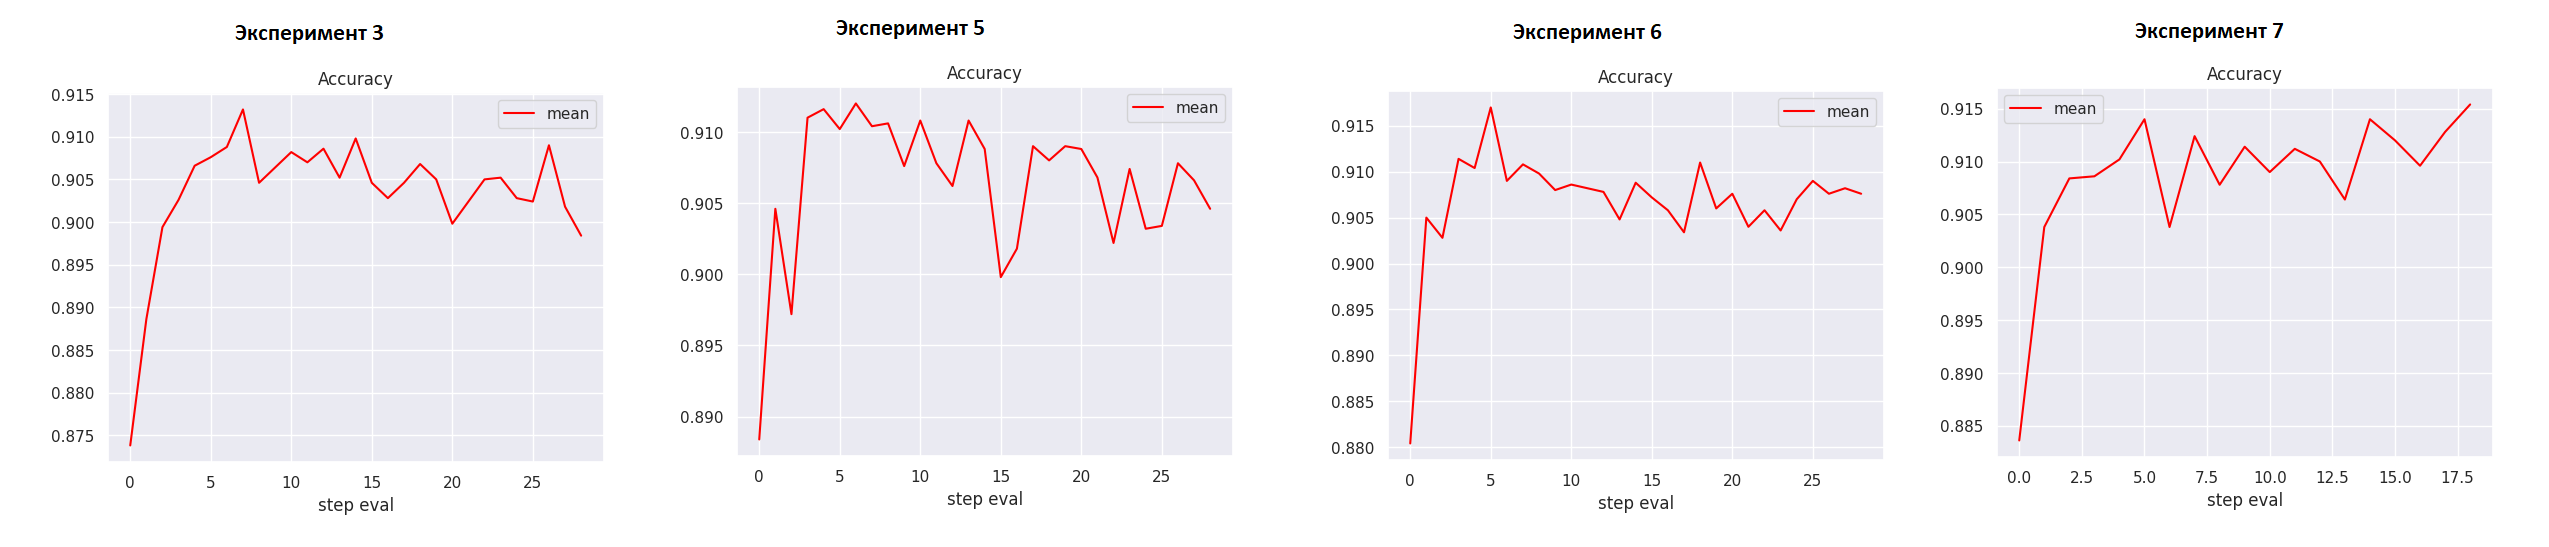